In [12]:
import os

with open(".env") as f:
    for line in f:
        # Ignore comments and empty lines
        if line.strip() and not line.startswith("#"):
            key, value = line.strip().split("=", 1)
            os.environ[key] = value

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")

#### Using Gemini for getting context of image

In [5]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://www.houseofhiranandani.com/vlogs/storage/2022/08/Blog-4-Feature-730x425.jpg",
    # Add yours here!
]

image_documents = load_image_urls(image_urls)

gemini_pro = GeminiMultiModal(model_name="models/gemini-pro-vision")

https://www.houseofhiranandani.com/vlogs/storage/2022/08/Blog-4-Feature-730x425.jpg


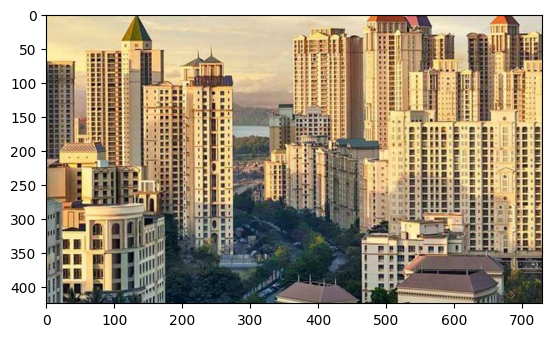

In [6]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

img_response = requests.get(image_urls[0])
print(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

In [10]:
stream_complete_response = gemini_pro.stream_complete(
    prompt="Give me more context for this image",
    image_documents=image_documents,
)

for r in stream_complete_response:
    print(r.text, end="")

 The image shows a skyline of Mumbai, India. It is a densely populated city with many high-rise buildings.

#### Using Gemini + Pydantic for structured output for description of image

In [13]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

In [14]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


In [15]:
from pathlib import Path

input_image_path = Path("google_restaurants")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

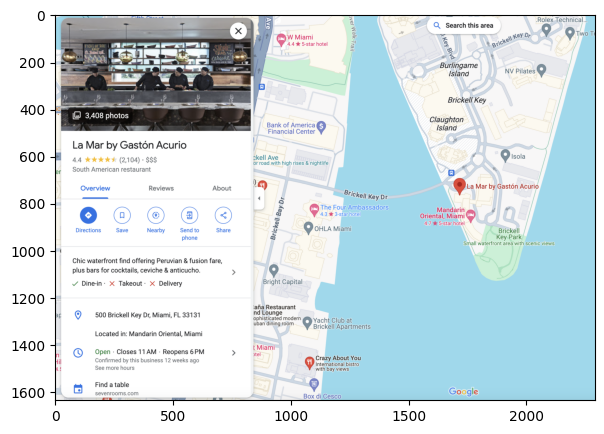

In [19]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt

class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "google_restaurants\miami_1.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

In [20]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

In [21]:
from llama_index.core import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./google_restaurants"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

> Raw output:  ```json
{
 "restaurant": "La Mar by Gaston Acurio",
 "food": "South American",
 "location": "500 Brickell Key Dr, Miami, FL 33131",
 "category": "Restaurant",
 "hours": "Open ⋅ Closes 11 PM",
 "price": "$100+",
 "rating": 4.4,
 "review": "4.4 (2,104)",
 "description": "La Mar by Gaston Acurio is a waterfront restaurant located in Miami, Florida. The restaurant offers a variety of Peruvian and fusion dishes, as well as a full bar. The restaurant has a casual atmosphere and is perfect for a night out with friends or family.",
 "nearby_tourist_places": "Brickell Key, Vizcaya Museum and Gardens, Bayside Marketplace"
}
```
('restaurant', 'La Mar by Gaston Acurio')
('food', 'South American')
('location', '500 Brickell Key Dr, Miami, FL 33131')
('category', 'Restaurant')
('hours', 'Open ⋅ Closes 11 PM')
('price', '$100+')
('rating', 4.4)
('review', '4.4 (2,104)')
('description', 'La Mar by Gaston Acurio is a waterfront restaurant located in Miami, Florida. The restaurant offers

#### Multi-Modal RAG for restaurant recommendation

In [22]:
from llama_index.core.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

In [23]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import Settings
from llama_index.core import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
Settings.embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
Settings.llm = Gemini(api_key=GOOGLE_API_KEY)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

In [24]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Miami restaurant for me and its nearby tourist places"
)
print(response)

For a delightful dining experience, I recommend La Mar by Gaston Acurio, a waterfront restaurant in Miami, Florida. This restaurant offers a diverse menu of Peruvian and fusion dishes, along with a full bar. Its casual atmosphere makes it perfect for a night out with friends or family.

After your meal, you can explore the nearby tourist attractions, such as Brickell Key, Vizcaya Museum and Gardens, and Bayside Marketplace. These places offer a variety of activities and experiences, ensuring an enjoyable and memorable visit.


In [26]:
response = query_engine.query(
    "recommend a Miami restaurant for me and its address as well"
)

print(response)

La Mar by Gaston Acurio, located at 500 Brickell Key Dr, Miami, FL 33131, is a highly-rated restaurant offering a variety of Peruvian and fusion dishes in a casual atmosphere.
